# Dilated CNN model

In this notebook, we demonstrate how to:
* prepare time series data for training a Convolutional Neural Network (CNN) forecasting model
* get data in the required shape for the keras API
* implement a CNN model in keras to predict the next step ahead (time t+1) in the time series
* enable early stopping to reduce the likelihood of model overfitting evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load data only.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/DeepLearningForTimeSeries')

In [3]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from glob import glob
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape
from common.extract_data import extract_data

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [4]:
!mkdir ./data
data_dir = './data'

if not os.path.exists(os.path.join(data_dir, 'energy.csv')):
    # Download and move the zip file
    !wget https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip
    !mv GEFCom2014.zip ./data
    # If not done already, extract zipped data and save as csv
    extract_data(data_dir)

--2024-09-22 14:43:50--  https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/pqenrr2mcvl0hk9/GEFCom2014.zip [following]
--2024-09-22 14:43:51--  https://www.dropbox.com/s/raw/pqenrr2mcvl0hk9/GEFCom2014.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6a240d361f920742b0231d7311.dl.dropboxusercontent.com/cd/0/inline/CbHDrwrFJXdKa5yOKMye2yBzyQP7qypafUVaSiM7_R_qzcPUzsAwLeyMK3Ath9AyEbFKk86wKvYXCABHzk9-laloasng9pmisZqsRJgvrteQ6IMtuFCux84h-eMcWsIwQInoGuXk8pbDh2c5bLxzmWvp/file# [following]
--2024-09-22 14:43:51--  https://uc6a240d361f920742b0231d7311.dl.dropboxusercontent.com/cd/0/inline/CbHDrwrFJXdKa5yOKMye2yBzyQP7qypafUVaSiM7_R_qzcPUzsAwLeyMK3Ath9AyEbFKk86wKvYXCABHzk9-laloasng9

Load data into Pandas dataframe

In [5]:
energy = load_data('data/')[['load']]
energy.head()

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


#Create train, validation and test sets

We separate our dataset into train, validation and test sets. We train the model on the train set. The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data. After the model has finished training, we evaluate the model on the test set. We must ensure that the validation set and test set cover a later period in time from the training set, to ensure that the model does not gain from information from future time periods.

We will allocate the period 1st November 2014 to 31st December 2014 to the test set. The period 1st September 2014 to 31st October is allocated to validation set. All other time periods are available for the training set.

In [6]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

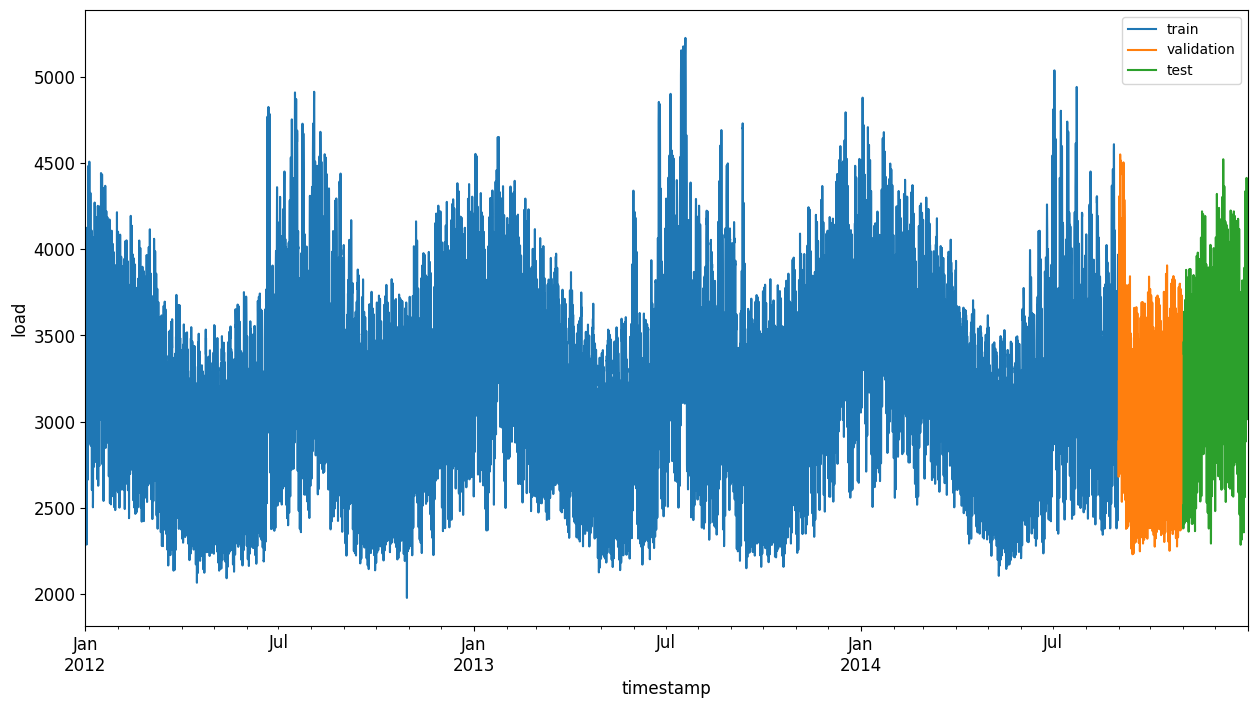

In [7]:


energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'train'}) \
    .join(energy[(energy.index >=valid_start_dt) & (energy.index < test_start_dt)][['load']] \
          .rename(columns={'load':'validation'}), how='outer') \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

#Data preparation - Training set

For this example, we will set T=10. This means that the input for each sample is a vector of the prevous 10 hours of the energy load. The choice of T=10 was arbitrary but should be selected through experimentation.

HORIZON=1 specifies that we have a forecasting horizon of 1 (t+1)

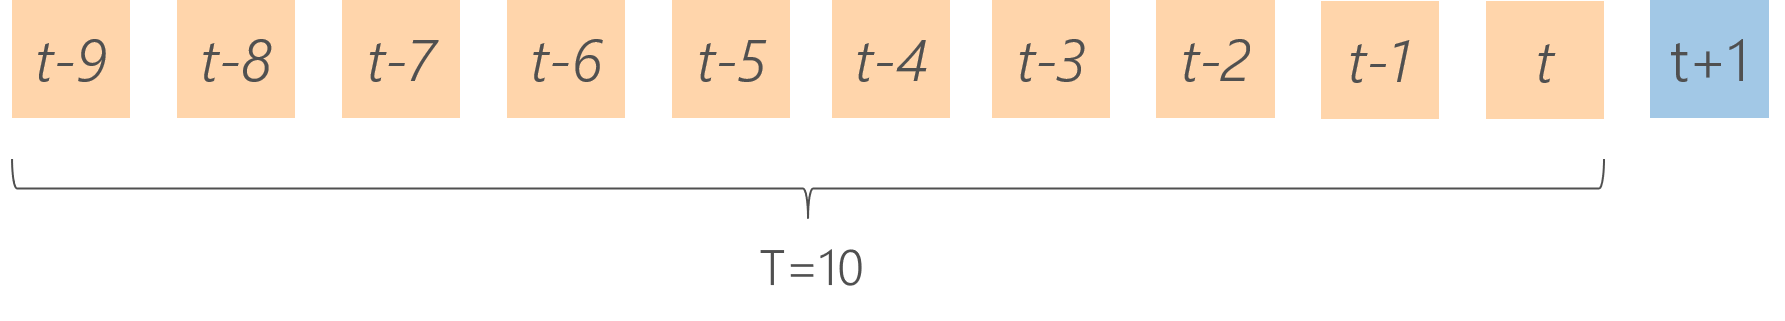

In [8]:
T = 10
HORIZON = 1

Our data preparation for the training set will involve the following steps:
1. Filter the original dataset to include only that time period reserved for the training set
2. Scale the time series such that the values fall within the interval (0, 1)
3. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
4. Discard any samples with missing values
5. Transform this Pandas dataframe into a numpy array of shape (samples, features) for input into Keras


# 1. Filter the original dataset to include only that time period reserved for the training set
Create training set containing only the model features

In [9]:
train = energy.copy()[energy.index < valid_start_dt][['load']]

# 2. Scale the time series such that the values fall within the interval (0, 1)

Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
2012-01-01 00:00:00,0.22
2012-01-01 01:00:00,0.18
2012-01-01 02:00:00,0.14
2012-01-01 03:00:00,0.13
2012-01-01 04:00:00,0.13
2012-01-01 05:00:00,0.15
2012-01-01 06:00:00,0.18
2012-01-01 07:00:00,0.23
2012-01-01 08:00:00,0.29
2012-01-01 09:00:00,0.35


Let us have a look at the original data with respect to the scaled data

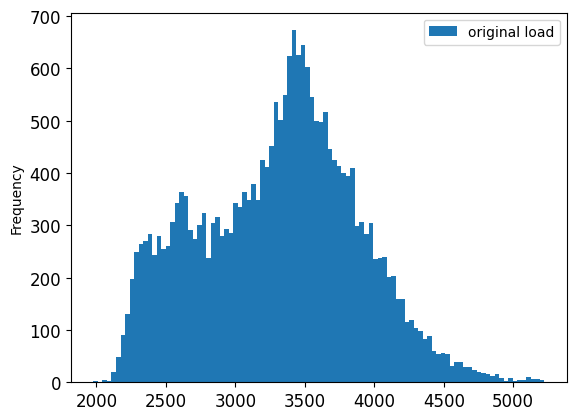

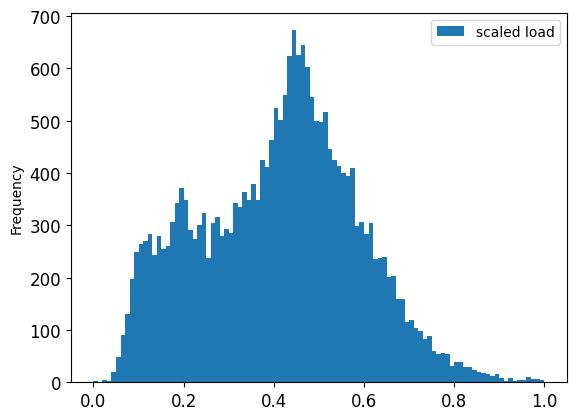

In [11]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

# 3. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
First, we create the target (y_t+1) variable. If we use the convention that the dataframe is indexed on time t, we need to shift the load variable forward one hour in time. Using the freq parameter we can tell Pandas that the frequency of the time series is hourly. This ensures the shift does not jump over any missing periods in the time series.

In [12]:
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')
train_shifted.head(10)

,load,y_t+1
2012-01-01 00:00:00,0.22,0.18
2012-01-01 01:00:00,0.18,0.14
2012-01-01 02:00:00,0.14,0.13
2012-01-01 03:00:00,0.13,0.13
2012-01-01 04:00:00,0.13,0.15
2012-01-01 05:00:00,0.15,0.18
2012-01-01 06:00:00,0.18,0.23
2012-01-01 07:00:00,0.23,0.29
2012-01-01 08:00:00,0.29,0.35
2012-01-01 09:00:00,0.35,0.37


We also need to shift the load variable back 6 times to create the input sequence:

In [13]:
for t in range(1, T+1):
    train_shifted['load_t-'+str(T-t)] = train_shifted['load'].shift(T-t, freq='H')
train_shifted = train_shifted.rename(columns={'load':'load_original'})
train_shifted.head(10)

,load_original,y_t+1,load_t-9,load_t-8,load_t-7,load_t-6,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
2012-01-01 00:00:00,0.22,0.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.22
2012-01-01 01:00:00,0.18,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.22,0.18
2012-01-01 02:00:00,0.14,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.22,0.18,0.14
2012-01-01 03:00:00,0.13,0.13,NaN,NaN,NaN,NaN,NaN,NaN,0.22,0.18,0.14,0.13
2012-01-01 04:00:00,0.13,0.15,NaN,NaN,NaN,NaN,NaN,0.22,0.18,0.14,0.13,0.13
2012-01-01 05:00:00,0.15,0.18,NaN,NaN,NaN,NaN,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,NaN,NaN,NaN,0.22,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,NaN,NaN,0.22,0.18,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,NaN,0.22,0.18,0.14,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.22,0.18,0.14,0.13,0.13,0.15,0.18,0.23,0.29,0.35


# 4. Discard any samples with missing values
Notice how we have missing values for the input sequences for the first 5 samples. We will discard these

In [14]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,load_original,y_t+1,load_t-9,load_t-8,load_t-7,load_t-6,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
2012-01-01 09:00:00,0.35,0.37,0.22,0.18,0.14,0.13,0.13,0.15,0.18,0.23,0.29,0.35
2012-01-01 10:00:00,0.37,0.37,0.18,0.14,0.13,0.13,0.15,0.18,0.23,0.29,0.35,0.37
2012-01-01 11:00:00,0.37,0.37,0.14,0.13,0.13,0.15,0.18,0.23,0.29,0.35,0.37,0.37
2012-01-01 12:00:00,0.37,0.36,0.13,0.13,0.15,0.18,0.23,0.29,0.35,0.37,0.37,0.37
2012-01-01 13:00:00,0.36,0.35,0.13,0.15,0.18,0.23,0.29,0.35,0.37,0.37,0.37,0.36


# 5. Transform into a numpy arrays of shapes (samples, time steps, features) and (samples,1) for input into Keras
Now convert the target variable into a numpy array.

In [15]:
y_train = train_shifted[['y_t+1']].to_numpy()

We now have a vector for target variable of shape:

In [16]:
y_train.shape

(23366, 1)

The target variable for the first 3 samples looks like:

In [17]:
y_train[:3]

array([[0.37],
       [0.37],
       [0.37]])

Now convert the inputs into a numpy array with shape (samples, time steps, features)

In [18]:
X_train = train_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_train = X_train[... , np.newaxis]

The tensor for the input features now has the shape:

In [19]:
X_train.shape

(23366, 10, 1)

And the first 3 samples looks like:

In [20]:
X_train[:3]

array([[[0.22],
        [0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23],
        [0.29],
        [0.35]],

       [[0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23],
        [0.29],
        [0.35],
        [0.37]],

       [[0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23],
        [0.29],
        [0.35],
        [0.37],
        [0.37]]])

In [21]:
train_shifted.head(3)

,load_original,y_t+1,load_t-9,load_t-8,load_t-7,load_t-6,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
2012-01-01 09:00:00,0.35,0.37,0.22,0.18,0.14,0.13,0.13,0.15,0.18,0.23,0.29,0.35
2012-01-01 10:00:00,0.37,0.37,0.18,0.14,0.13,0.13,0.15,0.18,0.23,0.29,0.35,0.37
2012-01-01 11:00:00,0.37,0.37,0.14,0.13,0.13,0.15,0.18,0.23,0.29,0.35,0.37,0.37


# Data preparation - validation set

Now we follow a similar process for the validation set. We keep T hours from the training set in order to construct initial features.


In [22]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]
valid.head()

,load
2014-08-31 15:00:00,"3,813.00"
2014-08-31 16:00:00,"3,859.00"
2014-08-31 17:00:00,"3,936.00"
2014-08-31 18:00:00,"3,957.00"
2014-08-31 19:00:00,"3,969.00"


Scale the series using the transformer fitted on the training set:

In [23]:
valid['load'] = scaler.transform(valid)
valid.head()

,load
2014-08-31 15:00:00,0.57
2014-08-31 16:00:00,0.58
2014-08-31 17:00:00,0.60
2014-08-31 18:00:00,0.61
2014-08-31 19:00:00,0.61


Prepare validation inputs in the same way as the training set:

In [24]:
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    valid_shifted['load_t-'+str(T-t)] = valid_shifted['load'].shift(T-t, freq='H')
valid_shifted = valid_shifted.dropna(how='any')
y_valid = valid_shifted['y+1'].to_numpy()
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_valid = X_valid[..., np.newaxis]

In [25]:
y_valid.shape

(1463,)

In [26]:
X_valid.shape

(1463, 10, 1)

# Implement the Convolutional Neural Network

We implement the convolutional neural network with 3 layers, 5 neurons in each layer, a kern
el size of 3 in each layer, and dilation rates of 1, 2 and 4 for each successive layer.

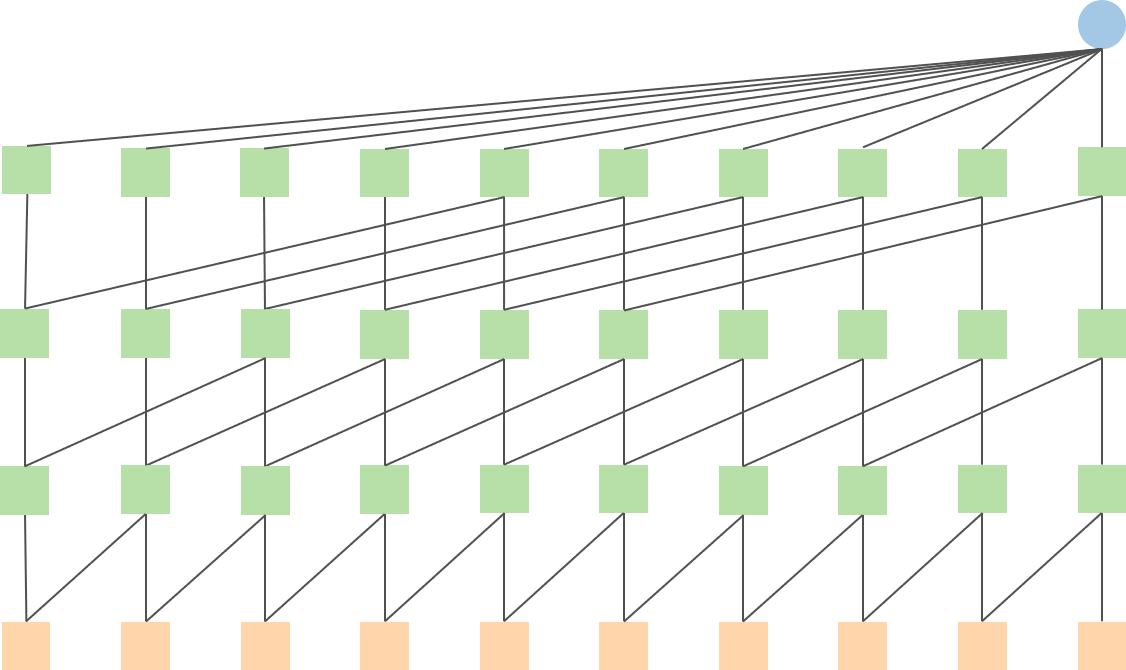


In [27]:
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [28]:
LATENT_DIM = 5 # Nombre de filtres
KERNEL_SIZE = 2
BATCH_SIZE = 32
EPOCHS = 10

In [29]:
model = Sequential()
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(T, 1)))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model.add(Flatten())
model.add(Dense(HORIZON, activation='linear'))

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 10, 5)               │              15 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 10, 5)               │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 5)               │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 176 (704.00 B)

 Trainable params: 176 (704.00 B)

 Non-trainable params: 0 (0.00 B)

Use Adam optimizer and mean squared error as the loss function.

In [31]:
model.compile(optimizer='Adam', loss='mse')

# Early stopping trick

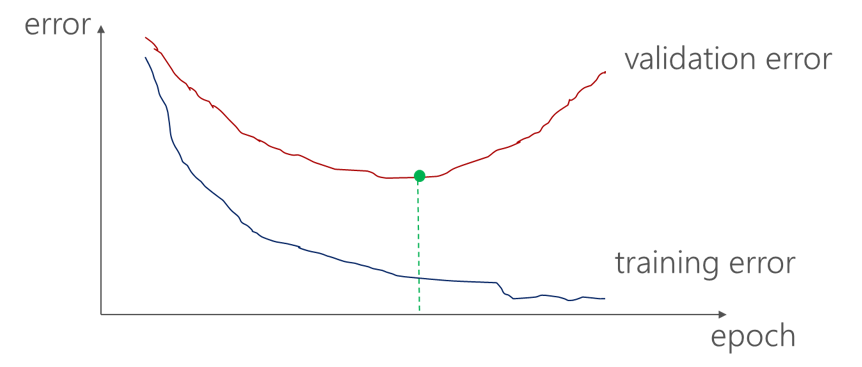

Specify the early stopping criteria. We **monitor** the validation loss (in this case the mean squared error) on the validation set after each training epoch. If the validation loss has not improved by **min_delta** after **patience** epochs, we stop the training.

In [32]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [48]:
!mkdir ./tmp
best_val = ModelCheckpoint('./tmp/model_{epoch:02d}.keras', save_best_only=False, mode='min', save_freq=1)

In [49]:
history = model.fit(X_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 4.8087e-04 - val_loss: 3.8060e-04
Epoch 2/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 4.7543e-04 - val_loss: 3.3509e-04
Epoch 3/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 4.6591e-04 - val_loss: 3.3981e-04
Epoch 4/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 4.6356e-04 - val_loss: 4.1076e-04
Epoch 5/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 4.4146e-04 - val_loss: 3.2260e-04
Epoch 6/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 4.4908e-04 - val_loss: 3.8684e-04
Epoch 7/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 4.4276e-04 - val_loss: 3.2680e-04
Epoch 8/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 4.3060e-04 - val_loss: 3.6079e-04
Epoch 9/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 4.2344e-04 - val_loss: 3.1285e-04
Epoch 10/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 4.2454e-04 - val_loss: 3.0800e-04


Load the model with the smallest mape

In [51]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("./tmp/model_{:02d}.keras".format(best_epoch))

plot training and validation losses

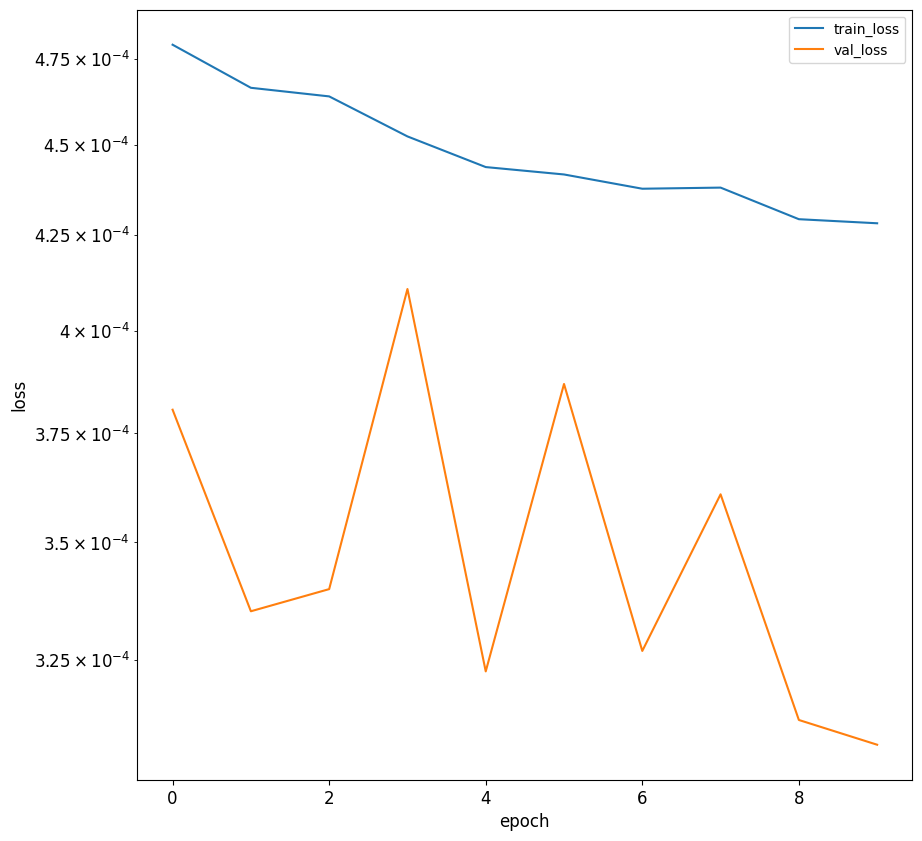

In [52]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

# Evaluate the model

Create the test set

In [53]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load']]
test.head()

,load
2014-11-01 00:00:00,"2,514.00"
2014-11-01 01:00:00,"2,434.00"
2014-11-01 02:00:00,"2,390.00"
2014-11-01 03:00:00,"2,382.00"
2014-11-01 04:00:00,"2,419.00"


Scale the data

In [54]:
test['load'] = scaler.transform(test)
test.head()

,load
2014-11-01 00:00:00,0.16
2014-11-01 01:00:00,0.14
2014-11-01 02:00:00,0.13
2014-11-01 03:00:00,0.12
2014-11-01 04:00:00,0.14


Create test set features

In [55]:
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    test_shifted['load_t-'+str(T-t)] = test_shifted['load'].shift(T-t, freq='H')
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted['y_t+1'].to_numpy()
X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_test = X_test[... , np.newaxis]

Make predictions on test set

In [56]:
predictions = model.predict(X_test)
predictions

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


array([[0.45],
       [0.44],
       [0.44],
       ...,
       [0.52],
       [0.44],
       [0.41]], dtype=float32)

Compare predictions to actual load

In [57]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 09:00:00,t+1,"3,425.80","3,436.00"
1,2014-11-01 10:00:00,t+1,"3,421.51","3,464.00"
2,2014-11-01 11:00:00,t+1,"3,411.90","3,439.00"
3,2014-11-01 12:00:00,t+1,"3,386.80","3,407.00"
4,2014-11-01 13:00:00,t+1,"3,377.49","3,389.00"


Compute the mean absolute percentage error over all predictions

In [58]:
mape(eval_df['prediction'], eval_df['actual'])

0.012126071512973062

Plot the predictions vs the actuals for the first week of the test set

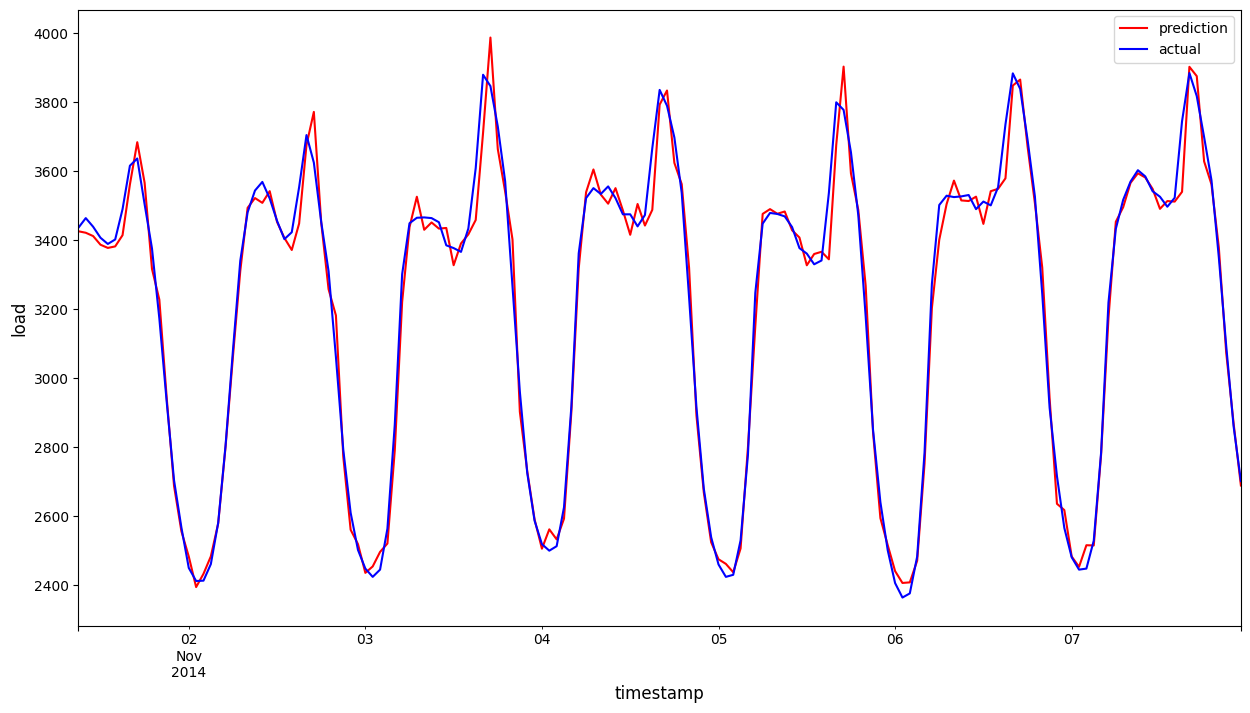

In [59]:
eval_df[eval_df.timestamp<'2014-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [ ]:
# clean up model files


for m in glob('./tmp/model_*.h5'):
    os.remove(m)

